# Classification of Chest x-ray scan for Pneumonia using Convolutional Neural Network

What is a chest x-ray?
The chest x-ray is the most commonly performed diagnostic x-ray examination. A chest x-ray produces images of the heart, lungs, airways, blood vessels and the bones of the spine and chest.

An x-ray exam helps doctors diagnose and treat medical conditions. It exposes you to a small dose of ionizing radiation to produce pictures of the inside of the body. X-rays are the oldest and most often used form of medical imaging.

What are some common uses of the procedure?\
The chest x-ray is performed to evaluate the lungs, heart and chest wall.

A chest x-ray is typically the first imaging test used to help diagnose symptoms such as:

- Breathing difficulties
- A bad or persistent cough
- Chest pain or injury
- Fever

Physicians use the examination to help diagnose or monitor treatment for conditions such as:

- Pneumonia
- Heart failure and other heart problems
- Emphysema
- Lung cancer
- Positioning of medical devices
- Fluid or air collection around the lungs
- Other medical conditions\
source:https://www.radiologyinfo.org/en/info/chestrad

# Importing the required libraries needed 

In [1]:
#get libraries
import os
import pathlib
import PIL
import PIL.Image

import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.math import confusion_matrix
import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data Loading and Preprocessing

In [3]:
#data location/directory
data_dir=pathlib.Path('C:/Users/val-c/Machine Learning_Deep Learning/xray chest scan')
data_dir


WindowsPath('C:/Users/val-c/Machine Learning_Deep Learning/xray chest scan')

In [4]:
dataset =tf.keras.utils.image_dataset_from_directory(
data_dir, batch_size=32, image_size=(256, 256))
for data, labels in dataset:
    print(data.shape) #32,256,256,3
    print(data.dtype) #float32
   
    break;


Found 188 files belonging to 2 classes.
(32, 256, 256, 3)
<dtype: 'float32'>


Examining the test and train classes in the directory

In [5]:
#trainsets subdirectories.-------
normal_train=pathlib.Path ('C:/Users/val-c/Machine Learning_Deep Learning/xray chest scan/train/NORMAL')
pneumo_train=pathlib.Path('C:/Users/val-c/Machine Learning_Deep Learning/xray chest scan/train/PNEUMONIA')
#testset subdirectories----------
normal_test=pathlib.Path('C:/Users/val-c/Machine Learning_Deep Learning/xray chest scan/test/NORMAL')
pneumo_test=pathlib.Path('C:/Users/val-c/Machine Learning_Deep Learning/xray chest scan/test/PNEUMONIA')

In [6]:
print("Train set Length",len(list(normal_train.glob('*.jpeg')))+len(list(pneumo_train.glob('*.jpeg'))))
print("Test set Length",len(list(normal_test.glob('*.jpeg')))+len(list(pneumo_test.glob('*.jpeg'))))

Train set Length 115
Test set Length 35


Exploring the image in the training set (Normal and pneumonia)

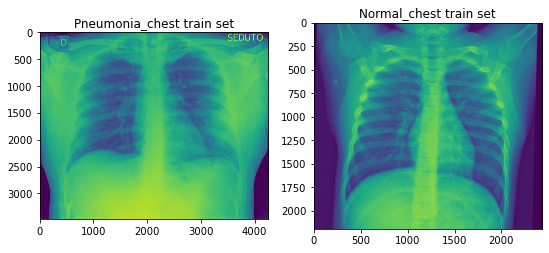

In [7]:
plt.figure(figsize=(9, 7)) #fig_sizing
#first figure
plt.subplot(1,2,1)
plt.imshow(cv2.imread("C:/Users/val-c/Machine Learning_Deep Learning/xray chest scan/train/PNEUMONIA/E1724330-1866-4581-8CD8-CEC9B8AFEDDE.jpeg",cv2.IMREAD_GRAYSCALE))
_=plt.title('Pneumonia_chest train set') #title

#2nd figure
plt.subplot(1,2,2) #subplot
plt.imshow(cv2.imread("C:/Users/val-c/Machine Learning_Deep Learning/xray chest scan/train/NORMAL/NORMAL2-IM-0033-0001.jpeg",cv2.IMREAD_GRAYSCALE))
_=plt.title('Normal_chest train set') #title
plt.show() #display.

# Spliting the datasets into train,validation and test sets, and Normalizing and Standardizing the data

In [8]:
train_images_dict={ 'normal':list(normal_train.glob('*.jpeg')), 'pneumonia':list(pneumo_train.glob('*.jpeg'))}# train dir..

test_images_dict={'normal':list(normal_test.glob('*.jpeg')), 'pneumonia':list(pneumo_test.glob('*.jpeg'))} #test dir...

labels_dict={'normal':0,'pneumonia':1} #####label

In [9]:
X,y=[],[]
for label,images in train_images_dict.items():
    for image in images:
        img=cv2.imread(str(image),0)
        img=cv2.resize(img,(200,200),interpolation=cv2.INTER_AREA)
        X.append(img)
        y.append(labels_dict[label])
        
X=np.array(X)
X=X/255  
y=np.array(y)

X_test,y_test=[],[]
for label,images in test_images_dict.items():
    for image in images:
        img=cv2.imread(str(image),0)
        img=cv2.resize(img,(200,200),interpolation=cv2.INTER_AREA)
        X_test.append(img)
        y_test.append(labels_dict[label])

X_test=np.array(X_test)
X_test=X_test/255 #rescaling
y_test=np.array(y_test)


In [10]:
# split the data sets and 20% would be used for testing while the rest would be used for training and validation
X_train,X_val,y_train,y_val=train_test_split(X,y,stratify=y,random_state=69,test_size=0.20)

In [11]:
X_train=np.expand_dims(X_train,-1)
X_test=np.expand_dims(X_test,-1)
X_val=np.expand_dims(X_val,-1)

In [12]:
print("Shape of Train Set",X_train.shape) # train set
print("Shape of Validation Set",X_val.shape) #validatin set...
print("Shape of Test Set",X_test.shape)# testing set....

Shape of Train Set (92, 200, 200, 1)
Shape of Validation Set (23, 200, 200, 1)
Shape of Test Set (35, 200, 200, 1)


The training data contains 200*200 pixels with 92 training sets, 35 datasets would be used for testing , while 23 would be used for validation.

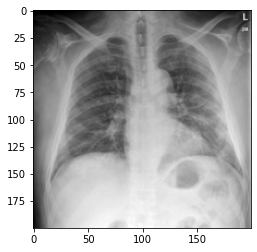

In [13]:
#result of the normalized training data
result=plt.imshow(X_train[5],cmap='gray') #display an image..


# Creating the model

The Convolutional Neural Network is used here which is ideal for medical images

In [14]:
#configuring the model..............

model = Sequential()
image_shape=(200,200,1)
#input layer........
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

#hidden layer........
model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

#Adding Dropouts to help reduce overfitting
model.add(Dropout(0.5))

#output layer, sigmoid used here for activation.........
model.add(Dense(1))
model.add(Activation("sigmoid"))


# Compiling the model

The Adam optimizer and the BinaryCrossentropy are used to compile the model

In [15]:
#using model.compile() to compile the model with the optimizer and loss function

model.compile(optimizer='adam',
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [16]:
model.summary() #compute model summary after compilation

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

In [17]:
#DataAugmentation generator........
datagen=ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

In [18]:
#stop training when a monitored metric has stopped improving
#earlystopping=tf.keras.callbacks.EarlyStopping(
    #patience=3,
   # monitor='val_loss',
   # mode='auto'
#)

# Train the model

In [19]:
#using the model.fit() to train data
history =model.fit(
    datagen.flow(X_train,y_train,batch_size=32),
    validation_data=datagen.flow(X_val,y_val,batch_size=32),
    shuffle=True,
    epochs=25
    #callbacks=[earlystopping]
)

Epoch 1/25
3/3 [==============================] - 8s 2s/step - loss: 0.7919 - accuracy: 0.5543 - val_loss: 0.6487 - val_accuracy: 0.7826
Epoch 2/25
3/3 [==============================] - 5s 2s/step - loss: 0.6472 - accuracy: 0.6196 - val_loss: 0.6237 - val_accuracy: 0.6522
Epoch 3/25
3/3 [==============================] - 4s 2s/step - loss: 0.6610 - accuracy: 0.6413 - val_loss: 0.6217 - val_accuracy: 0.6522
Epoch 4/25
3/3 [==============================] - 5s 2s/step - loss: 0.6252 - accuracy: 0.6413 - val_loss: 0.6188 - val_accuracy: 0.6522
Epoch 5/25
3/3 [==============================] - 5s 2s/step - loss: 0.6410 - accuracy: 0.6413 - val_loss: 0.6031 - val_accuracy: 0.6522
Epoch 6/25
3/3 [==============================] - 5s 2s/step - loss: 0.6149 - accuracy: 0.6413 - val_loss: 0.5687 - val_accuracy: 0.6522
Epoch 7/25
3/3 [==============================] - 4s 2s/step - loss: 0.5884 - accuracy: 0.6413 - val_loss: 0.5535 - val_accuracy: 0.6522
Epoch 8/25
3/3 [=========================

In [20]:
# view the training history in pandas df
import pandas as pd
losses = pd.DataFrame(history.history)
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,0.791936,0.554348,0.648710,0.782609
1,0.647250,0.619565,0.623730,0.652174
2,0.661011,0.641304,0.621651,0.652174
3,0.625205,0.641304,0.618773,0.652174
4,0.641046,0.641304,0.603069,0.652174


# Visualizing training results

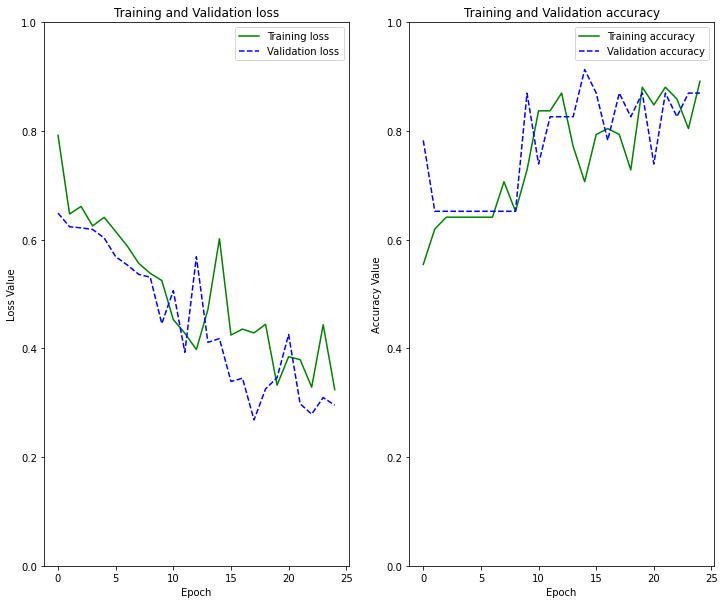

In [21]:
#training history
loss = history.history['loss']
val_loss = history.history['val_loss']
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

#Training and Validation loss
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, loss, 'g', label='Training loss')
plt.plot(history.epoch, val_loss, 'b--', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()

#Training and Validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, acc, 'g', label='Training accuracy')
plt.plot(history.epoch, val_acc, 'b--', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0, 1])
plt.legend()

#display plot
plt.show()

# Evaluate  accuracy on the test set

In [22]:
#evaluate on test data
model.evaluate(X_test,y_test)

2/2 [==============================] - 1s 48ms/step - loss: 0.0651 - accuracy: 1.0000


[0.0650564506649971, 1.0]

# Making prediction on the test set

In [23]:
#predict on test data
predictions = model.predict(X_test)
print(predictions.shape)

2/2 [==============================] - 1s 46ms/step
(35, 1)


In [24]:
cf_matrix=confusion_matrix(y_test,model.predict(X_test)>0.5)
cf_matrix

2/2 [==============================] - 0s 45ms/step


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[20,  0],
       [ 0, 15]])>

In [25]:
#classification measure plot
def plot_conf(cf_matrix):
    ax = sns.heatmap(cf_matrix, annot=True, cmap='viridis')

    ax.set_title(' Confusion Matrix:Testing');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    #Tick labels 
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])

    #Display Matrix
    plt.show()

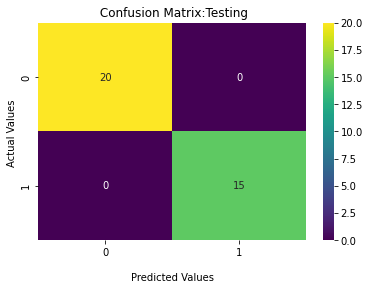

In [26]:
#visualize performance
plot_conf(cf_matrix) 

Out of the 35 xray chest scans, the model predicted that 20 of it, do not have pneumonia :(True Positive), while the remaining 15 were predicted to have pneumonia :(True Negative)

# Saving model

In [27]:
model.save('chest xray pneumonia')

INFO:tensorflow:Assets written to: chest xray pneumonia\assets


INFO:tensorflow:Assets written to: chest xray pneumonia\assets
